<a href="https://colab.research.google.com/github/MoniqueRon/NLP-Ex04/blob/main/Assignment_4_RC_Yonatan_and_Monique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4
## Training a DNN for relation classification

In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.


**In this work we will use the hugingface framework for transformers training and inference.**
We recomand reading the documentation in [this](https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertForSequenceClassification) link *before* you start coding.


All additional packages:

In [ ]:
!pip install --q
!pip install --q transformers

ERROR: You must give at least one requirement to install (see "pip help install")
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.5 MB/s eta 0:00:00


All imports: (You may add/change)

In [ ]:
# general
import os
import random
import warnings
from typing import List,Tuple
import re
from sklearn.metrics import classification_report,confusion_matrix


# ML
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn

# HF
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AutoTokenizer, AutoModel, AutoConfig

Set warnings filter to ignore:

In [ ]:
warnings.filterwarnings("ignore")

Set random SEEDs:

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Set GPU:

In [ ]:

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

## Dataset


The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf).
The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)

> Train file: `nlp-course/TRAIN_FILE.TXT`
> Test file: `nlp-course/TEST_FILE_FULL.TXT`


In [ ]:
!git clone https://github.com/kfirbar/nlp-course

Cloning into 'nlp-course'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 71 (delta 29), reused 40 (delta 11), pack-reused 0
Unpacking objects: 100% (71/71), 11.28 MiB | 5.62 MiB/s, done.


## Task #1

Write a funtion `read_data` for reading the data from a single file (either train or test).

<br>

This function recieves a filepath and returns a list of sentences; Every sentence is encoded as a tuple.

The first element is the sentence string.
The second element is the label (also represented as a sting).

In [ ]:
def read_data(filepath:str) -> List[Tuple[str,str]]:
    data = []
    with open(filepath, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()

        # Iterate over the lines in groups of three
        for i in range(0, len(lines), 4):
            sentence = lines[i].strip().split('\t')[1]
            sentence = re.findall(r'"([^"]*)"', sentence)[0]
            label = lines[i+1].strip()
            label = label.replace('(e1,e2)', '').replace('(e2,e1)', '').strip()
            data.append((sentence, label))
    return data

train = read_data('/content/nlp-course/TRAIN_FILE.TXT')
test = read_data('/content/nlp-course/TEST_FILE_FULL.TXT')

print('Number of train sentences:', len(train))
print('Number of test sentences:', len(test))

Number of train sentences: 8000
Number of test sentences: 2717


In [ ]:
print(train[:300])

df_train = pd.DataFrame(train, columns=['sentence', 'label'])
df_test = pd.DataFrame(test, columns=['sentence', 'label'])

print(df_train[:300])

[('The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>.', 'Component-Whole'), ('The <e1>child</e1> was carefully wrapped and bound into the <e2>cradle</e2> by means of a cord.', 'Other'), ('The <e1>author</e1> of a keygen uses a <e2>disassembler</e2> to look at the raw assembly code.', 'Instrument-Agency'), ('A misty <e1>ridge</e1> uprises from the <e2>surge</e2>.', 'Other'), ('The <e1>student</e1> <e2>association</e2> is the voice of the undergraduate student population of the State University of New York at Buffalo.', 'Member-Collection'), ("This is the sprawling <e1>complex</e1> that is Peru's largest <e2>producer</e2> of silver.", 'Other'), ('The current view is that the chronic <e1>inflammation</e1> in the distal part of the stomach caused by Helicobacter pylori <e2>infection</e2> results in an increased acid production from the non-infected upper corpus region of the stomach.', 'Cause-Effect'), ('<e1>People<

`Pytorch` require the labels to be integers.

Create a mapper (dictionary) from the string labels to integers (starting zero).
And a dictionary from label to integer.

In [ ]:
def create_label_mapper(data):
    label_mapper = {}
    label2id = {}
    for label in data["label"]:
        if label not in label_mapper:
            label_mapper[label] = len(label_mapper)
            label2id[label_mapper[label]] = label
    return label_mapper, label2id


label_mapper, label2id = create_label_mapper(df_train)
id2label = {v: k for k, v in label_mapper.items()}
label2id = {k: v for k, v in label_mapper.items()}

assert len(id2label) == len(label2id)
print('id2label: \n',id2label)
print('label2id: \n',label2id)

id2label: 
 {0: 'Component-Whole', 1: 'Other', 2: 'Instrument-Agency', 3: 'Member-Collection', 4: 'Cause-Effect', 5: 'Entity-Destination', 6: 'Content-Container', 7: 'Message-Topic', 8: 'Product-Producer', 9: 'Entity-Origin'}
label2id: 
 {'Component-Whole': 0, 'Other': 1, 'Instrument-Agency': 2, 'Member-Collection': 3, 'Cause-Effect': 4, 'Entity-Destination': 5, 'Content-Container': 6, 'Message-Topic': 7, 'Product-Producer': 8, 'Entity-Origin': 9}


<br>

Plot the distribution of labels in each dataset.
Display the information in a single plot.

For example:

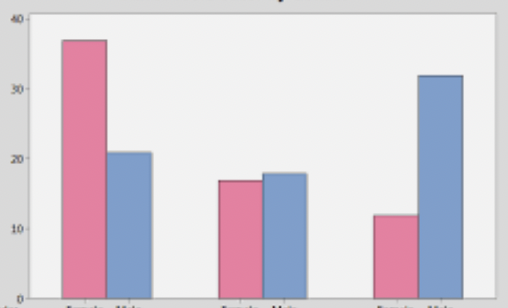

- Use bar plot.
- Use figuresize of (16,6).
- Add titles and Axis names.
- Y-axis will hold the count for each label.
- X-axis will hold the name of each label.

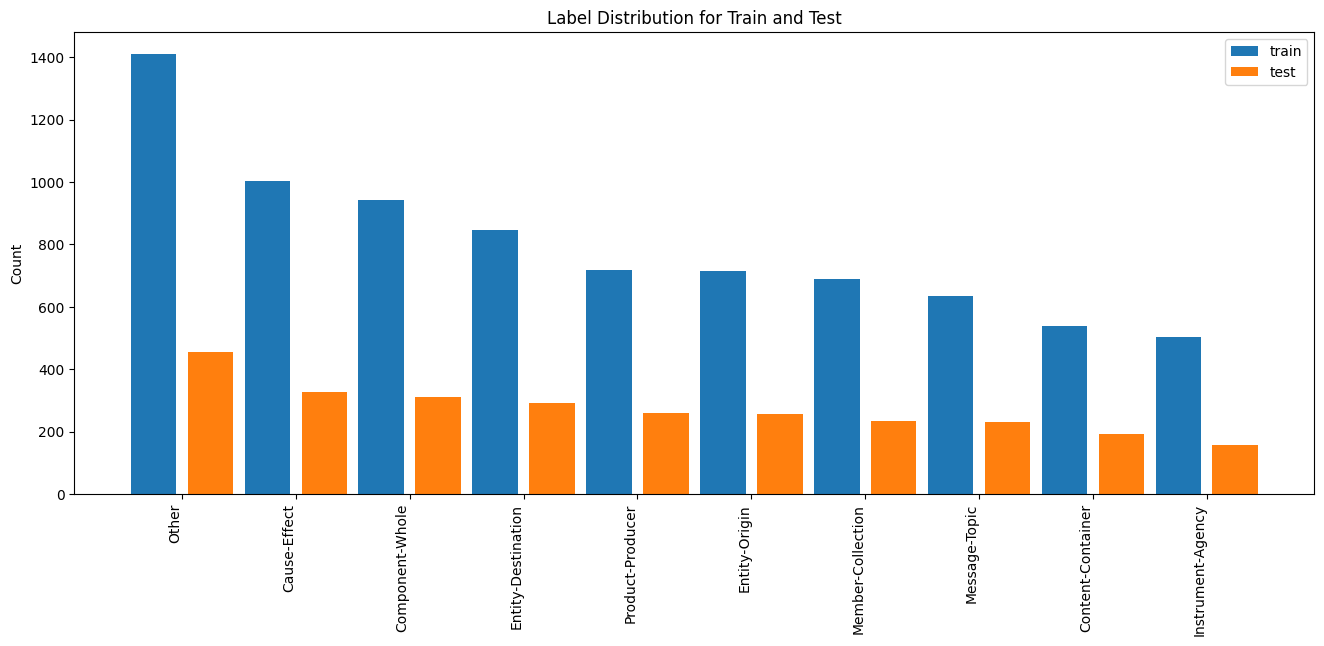

In [ ]:
def plot_label_distribution(data_1, data_2, title):
#    plot 2 bars next to each other wtch with half width
    fig, ax = plt.subplots(figsize=(16,6))
    ax.bar(np.arange(len(label_mapper)), data_1['label'].value_counts().values, width=0.4, label='train')
    ax.bar(np.arange(len(label_mapper))+0.5, data_2['label'].value_counts().values, width=0.4, label='test')
    ax.set_xticks(np.arange(len(label_mapper))+0.25)
    ax.set_xticklabels(data_1['label'].value_counts().index)
    ax.set_title(title)
    ax.set_ylabel('Count')
    plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
    ax.legend()
    plt.show()




plot_label_distribution(df_train, df_test, 'Label Distribution for Train and Test')

<br>

<br><br><br><br>


## Task #2

Download the relevant BERT tokenizer.
Use `bert-base-uncased` .


In [ ]:
# TO DO
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('...')

Write a function `prepare_data` that takes one of the `train & test` datasets and convert each pair of `(words,labels)` to a pair of indexes.

The function also aggregate the samples into batches.

BERT Uses pretrained tokanization and embedding.
you can access the tokanization and indexing using the `BertTokenizer` class.

Note: you may use `torch.utils.data.Dataset`

In [ ]:
import torch.utils.data as data_utils
from torch.nn.utils.rnn import pad_sequence

def prepare_data(data, tokenizer, batch_size=8):
    data_sequences = [(tokenizer.encode(sentence), label2id[label]) for sentence, label in data]
    # Convert the data to a DataFrame
    data_sequences_df = pd.DataFrame(data_sequences, columns=['tokens', 'label_id'])
    # Convert the data to PyTorch DataLoader objects
    dataset = data_utils.TensorDataset(
    pad_sequence([torch.tensor(seq) for seq in data_sequences_df['tokens'].tolist()], batch_first=True),
    torch.tensor(data_sequences_df['label_id'].tolist())
    )
    dataloader = data_utils.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# split the train dataset into train and validation
train_size = int(0.8 * len(train))
val_size = len(train) - train_size
train_dataset, val_dataset = data_utils.random_split(train, [train_size, val_size])

train_dataloader = prepare_data(train_dataset, tokenizer)

val_dataloader = prepare_data(val_dataset, tokenizer)

test_dataloader = prepare_data(test, tokenizer)

In [ ]:
train_sequences_iter = iter(train_dataloader)
for i in range(1):
    sequence = next(train_sequences_iter)
    print(sequence)

print(len(train_dataloader))

[tensor([[  101,  3383,  2130,  ...,     0,     0,     0],
        [  101,  1996,  6614,  ...,     0,     0,     0],
        [  101,  1045,  2031,  ...,     0,     0,     0],
        ...,
        [  101,  2004,  1996,  ...,     0,     0,     0],
        [  101,  1996, 20196,  ...,     0,     0,     0],
        [  101,  2043,  6519,  ...,     0,     0,     0]]), tensor([1, 7, 1, 0, 3, 6, 9, 3])]
800


<br><br><br><br>

## Task #3

In this part we classify the sentences using the `BertForSequenceClassification` model.


Download the relevant BERT model. Use `bert-base-uncased` .

In [ ]:
# TO DO
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(id2label))

# model = BertForSequenceClassification.from_pretrained('...')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i


Write a function `get_parameters` that gets the model as an input and return the top(final) layer of the model for a `torch` optimizer.

Note: take a look at these links [link1](https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6#:~:text=%3E%3E%3E-,for%20name%2C%20para%20in%20net.named_parameters()%3A,-...%20%20%20%20%20para.requires_grad%20%3D%20False) [link2](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) .


In [ ]:
def get_layer_parameters(params):
    layer_params = []
    layer_names = ['classifier', 'pooler', 'layer.11']
    for name, param in params:
        if any(layer_name in name for layer_name in layer_names):
            layer_params.append(param)
    return layer_params

all_model_params = model.named_parameters()
top_layer_params = get_layer_parameters(all_model_params)

for name, param in model.named_parameters():
    param.requires_grad = False

for param in top_layer_params:
    param.requires_grad = True


Define the optimizer:

- Use the `ADAM` optimizer (from `torch.optim`), which is a fancy version of SGD.
- Use a learning rate of 0.0001.
- Send only the top/final layer of the model to the optimizer (use `top_layer_params`).


In [ ]:
optimizer = torch.optim.Adam(top_layer_params, lr=0.0001)

<br><br><br><br>

## Task #4

Let's create the trainig function!


1. Write a training function, which takes a the model `BertForSequenceClassification` and number of epochs to train on.

2. Set `criterion` to the `CrossEntropyLoss` (from `torch.nn`) and use the `ADAM` optimizer.

3. Use a simple `for` loop to iterate over the epochs.
Use [tqdm](https://github.com/tqdm/tqdm) to mark your iteration and progress.

Notes:
- You may to split the `train` to `train&dev` sets.
- You may change the input/output of the training function.


In [ ]:
def evaluate(model, dataloader, criterion, rflag=False):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            sentences, labels = batch
            output = model(sentences.to(DEVICE))
            _, predicted = torch.max(output.logits, 1)
            if rflag:
                y_true.extend(labels.tolist())
                y_pred.extend(predicted.tolist())
            else:
                loss += criterion(output.logits, labels.to(DEVICE)).item()
                total += labels.size(0)
                correct += (predicted == labels.to(DEVICE)).sum().item()
    if rflag:
        return y_true, y_pred
    return loss / len(dataloader), correct / total

def training(model, n_epochs, train_dataloader, dev_dataloader, optimizer, criterion):
    model.to(DEVICE)
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for batch in train_dataloader:
            sentences, labels = batch
            # Clear gradients
            optimizer.zero_grad()
            # Get the model output for the batch
            output = model(sentences.to(DEVICE))
            # Calculate the loss
            loss = criterion(output.logits, labels.to(DEVICE))
            # Calculate the gradients for weights & biases using back-propagation
            loss.backward()
            # Update the weights & biases
            optimizer.step()
            # Add the loss to the training set's running loss
            train_loss += loss.item()
            # Calculate the number of correct predictions
            _, predicted = torch.max(output.logits, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels.to(DEVICE)).sum().item()
        # Calculate the train accuracy
        train_acc = train_correct / train_total
        # Calculate the train loss
        train_loss = train_loss / len(train_dataloader)
        # Append the train loss and accuracy to the history
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        # Calculate the validation loss and accuracy
        val_loss, val_acc = evaluate(model, dev_dataloader, criterion)
        # Append the validation loss and accuracy to the history
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        print('Epoch: {}/{} | Train loss: {:.3f} | Train acc: {:.3f} | Val loss: {:.3f} | Val acc: {:.3f}'.format(epoch+1, n_epochs, train_loss, train_acc, val_loss, val_acc))
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

train_loss_history, val_loss_history, train_acc_history, val_acc_history = training(model, 7, train_dataloader, val_dataloader, optimizer, criterion)

torch.save(model.state_dict(), 'model_part_4.pth')

 14%|█▍        | 1/7 [01:14<07:28, 74.72s/it]

Epoch: 1/7 | Train loss: 1.416 | Train acc: 0.498 | Val loss: 0.879 | Val acc: 0.703


 29%|██▊       | 2/7 [02:31<06:20, 76.20s/it]

Epoch: 2/7 | Train loss: 0.817 | Train acc: 0.714 | Val loss: 0.816 | Val acc: 0.724


 43%|████▎     | 3/7 [03:48<05:06, 76.57s/it]

Epoch: 3/7 | Train loss: 0.689 | Train acc: 0.758 | Val loss: 0.760 | Val acc: 0.745


 57%|█████▋    | 4/7 [05:06<03:50, 76.76s/it]

Epoch: 4/7 | Train loss: 0.617 | Train acc: 0.776 | Val loss: 0.771 | Val acc: 0.731


 71%|███████▏  | 5/7 [06:23<02:33, 76.95s/it]

Epoch: 5/7 | Train loss: 0.550 | Train acc: 0.798 | Val loss: 0.720 | Val acc: 0.756


 86%|████████▌ | 6/7 [07:40<01:17, 77.01s/it]

Epoch: 6/7 | Train loss: 0.502 | Train acc: 0.818 | Val loss: 0.717 | Val acc: 0.767


100%|██████████| 7/7 [08:57<00:00, 76.77s/it]

Epoch: 7/7 | Train loss: 0.457 | Train acc: 0.838 | Val loss: 0.744 | Val acc: 0.762


In [ ]:
# load the model into model
model.load_state_dict(torch.load('model_part_4.pth'))

<All keys matched successfully>

<br><br><br><br>

## Task #5

Write an evaluation loop on a trained model, using the test dataset.

Instructions:
> Input: model, data
> Output: Report, Confusion matrix

> 1. Display: Report, Confusion matrix
> 2. Save: a csv report


Explanation:
This function will perform an evaluation over a model with a dataset.
Calculate the `PERCISION, RECALL, F1` scores of each label seperately, and display them in a table.

Display a confusion matrix plot: where the predicted labels are the rows, and the true labels are the columns.


In addition, load thwe report to a dataframe and save to a CSV with this name:

> `{student_id_1}_{student_id_n}_part5.csv`
For example: `300123123_200456789_part_5.csv`



In [ ]:
cols   = ['PERCISION','RECALL','F1','SUPPORT']
labels = ['Other', 'Cause-Effect', 'Component-Whole', 'Content-Container', 'Entity-Destination', 'Entity-Origin', 'Instrument-Agency', 'Member-Collection', 'Message-Topic', 'Product-Producer']

y_true, y_pred = evaluate(model, test_dataloader,criterion, rflag=True)


                    precision    recall  f1-score   support

   Component-Whole       0.73      0.89      0.80       312
             Other       0.59      0.42      0.49       454
 Instrument-Agency       0.79      0.70      0.74       156
 Member-Collection       0.67      0.92      0.77       233
      Cause-Effect       0.88      0.93      0.90       328
Entity-Destination       0.88      0.92      0.90       292
 Content-Container       0.86      0.86      0.86       192
     Message-Topic       0.85      0.80      0.82       261
  Product-Producer       0.77      0.79      0.78       231
     Entity-Origin       0.86      0.77      0.81       258

          accuracy                           0.78      2717
         macro avg       0.79      0.80      0.79      2717
      weighted avg       0.77      0.78      0.77      2717



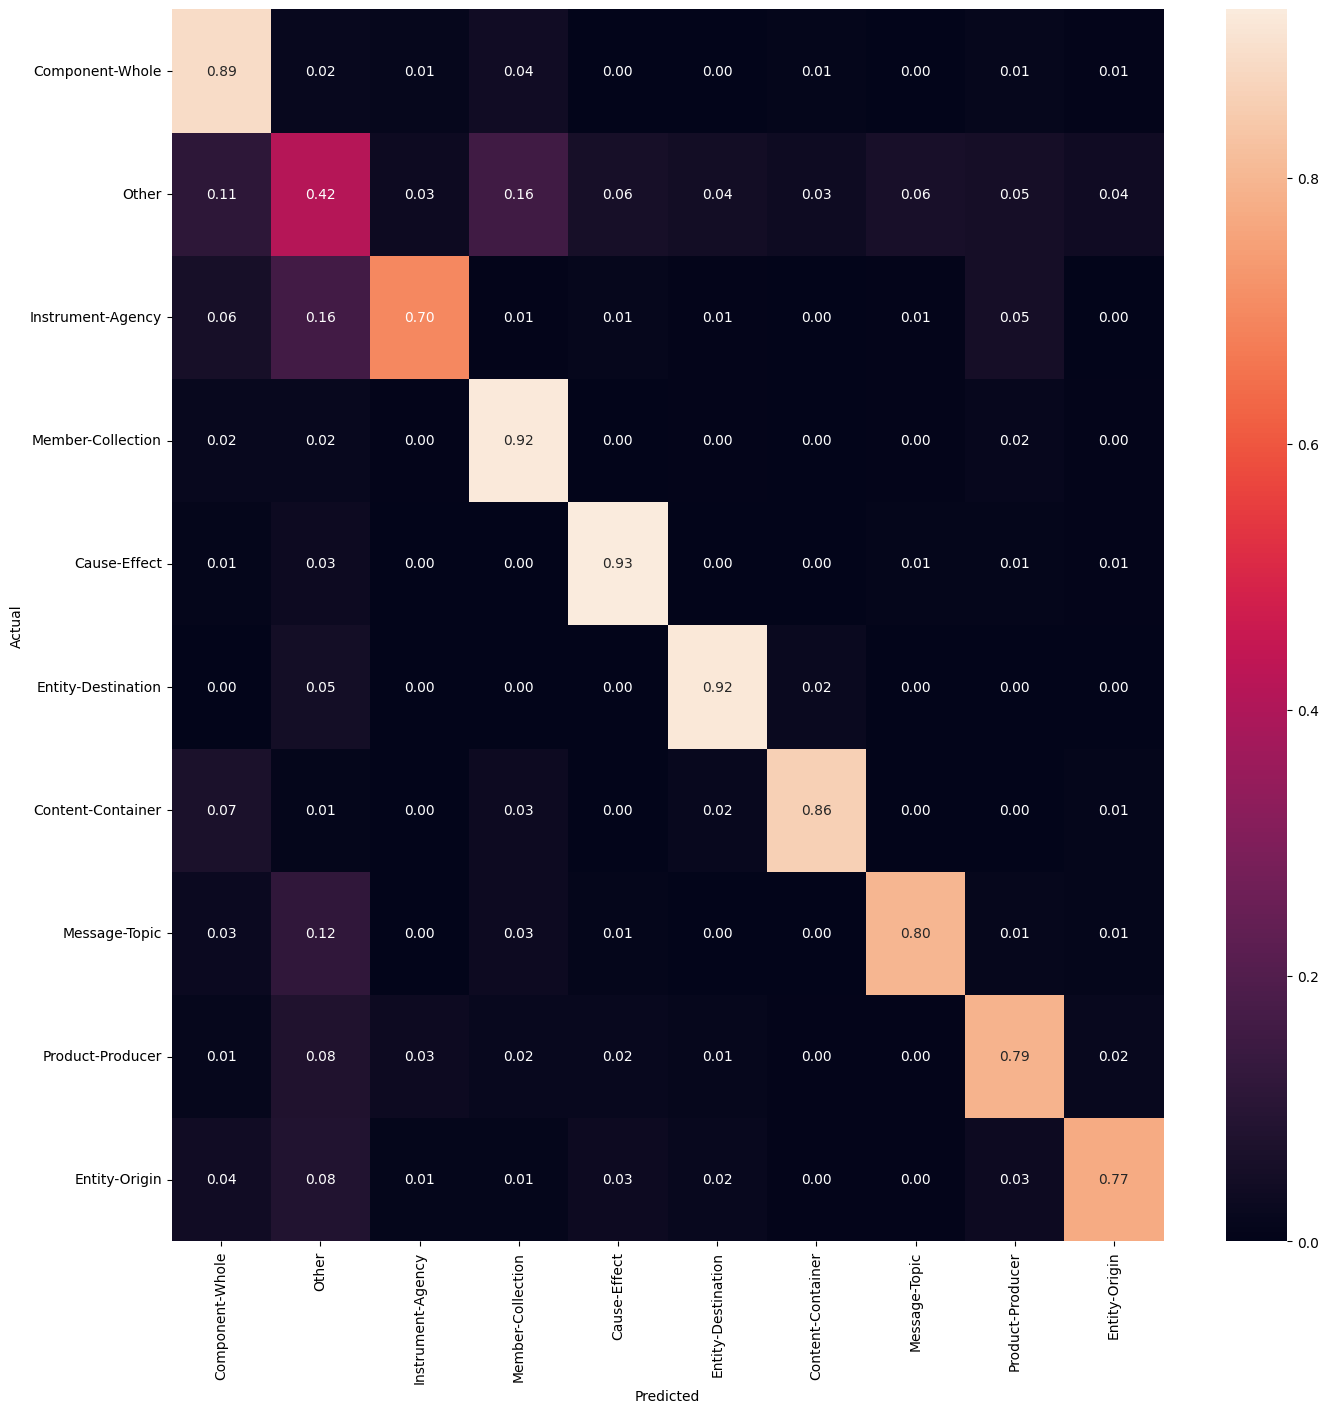

In [ ]:

print(classification_report(y_true, y_pred, target_names=label_mapper))


# save()
def save():
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(16, 16))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=label_mapper, yticklabels=label_mapper)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('confusion_matrix.png')

save()

In [ ]:
# Example:
# results_acc = np.random.rand(10, 4)
# df = pd.DataFrame(results_acc,columns=cols)
# df.index = labels
# print(tabulate(df, headers='keys', tablefmt='psql',floatfmt=".4f"))

In [ ]:
df = pd.DataFrame(classification_report(y_true, y_pred, target_names=label_mapper, output_dict=True)).transpose()
# df = df.drop(columns=['support'])
df = df.drop(index=['accuracy','macro avg','weighted avg'])
df = df.round(4)
print(tabulate(df, headers='keys', tablefmt='psql',floatfmt=".4f"))

+--------------------+-------------+----------+------------+-----------+
|                    |   precision |   recall |   f1-score |   support |
|--------------------+-------------+----------+------------+-----------|
| Component-Whole    |      0.7309 |   0.8878 |     0.8017 |  312.0000 |
| Other              |      0.5888 |   0.4163 |     0.4877 |  454.0000 |
| Instrument-Agency  |      0.7899 |   0.6987 |     0.7415 |  156.0000 |
| Member-Collection  |      0.6656 |   0.9227 |     0.7734 |  233.0000 |
| Cause-Effect       |      0.8761 |   0.9268 |     0.9007 |  328.0000 |
| Entity-Destination |      0.8816 |   0.9178 |     0.8993 |  292.0000 |
| Content-Container  |      0.8594 |   0.8594 |     0.8594 |  192.0000 |
| Message-Topic      |      0.8525 |   0.7969 |     0.8238 |  261.0000 |
| Product-Producer   |      0.7722 |   0.7922 |     0.7821 |  231.0000 |
| Entity-Origin      |      0.8578 |   0.7713 |     0.8122 |  258.0000 |
+--------------------+-------------+----------+----

In [ ]:
df.to_csv('{208542944}_{318339041}_part5.csv.csv', index=False)

<br><br><br><br>

### Task #6

In this part we'll improve the model accuracy by using a method called "entity markers - Entity start".

The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. Instead of using the `CLS token` for clasification, we will use the concatination of the embedding of `[e1]` and `[e2]` as shown in the image below.

The complete method is described in details in the paper [Matching the Blanks: Distributional Similarity for Relation Learning following](https://arxiv.org/pdf/1906.03158.pdf) (specifically in Section 3.2).

 To use this method we'll need to create a new data load and a new model.

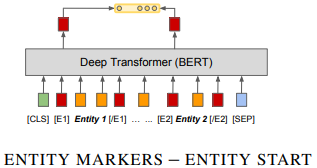

The new methods require the usage of special tokens.
Fix the following code so it will add the required tokens:

In [ ]:
E1_START = '<e1>'
E1_END   = '</e1>'
E2_START = '<e2>'
E2_END   = '</e2>'

entity_markers = [E1_START, E1_END, E2_START, E2_END]
mtb_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mtb_tokenizer.add_tokens(entity_markers)

4

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

Note: you may change the classes, function, etc.

In [ ]:
label_mapper, label2id = create_label_mapper(df_train)
id2label = {v: k for k, v in label_mapper.items()}
label2id = {k: v for k, v in label_mapper.items()}

assert len(id2label) == len(label2id)
print('id2label: \n',id2label)
print('label2id: \n',label2id)

id2label: 
 {0: 'Component-Whole', 1: 'Other', 2: 'Instrument-Agency', 3: 'Member-Collection', 4: 'Cause-Effect', 5: 'Entity-Destination', 6: 'Content-Container', 7: 'Message-Topic', 8: 'Product-Producer', 9: 'Entity-Origin'}
label2id: 
 {'Component-Whole': 0, 'Other': 1, 'Instrument-Agency': 2, 'Member-Collection': 3, 'Cause-Effect': 4, 'Entity-Destination': 5, 'Content-Container': 6, 'Message-Topic': 7, 'Product-Producer': 8, 'Entity-Origin': 9}


In [ ]:
def prepare_data_MTB(data_df, tokenizer, batch_size=8):
    sequences = []
    for index, row in data_df.iterrows():
        sentence = row['sentence']
        label = row['label']
        tokens = tokenizer.tokenize(sentence)

        entity_indexes = []
        for marker in entity_markers:
            if marker in tokens:
                entity_indexes.append(tokens.index(marker))
            else:
                entity_indexes.append(None)

        if None not in entity_indexes:
            label_id = label2id[label]
            token_ids = tokenizer.convert_tokens_to_ids(tokens)
            sequences.append((token_ids, label_id, tuple(entity_indexes)))

    return sequences

In [ ]:
train_sequences = prepare_data_MTB(df_train, mtb_tokenizer, batch_size=8)
test_sequences = prepare_data_MTB(df_test, mtb_tokenizer, batch_size=8)

train_sequences_df = pd.DataFrame(train_sequences, columns=['tokens', 'label_id', 'indices'])
test_sequences_df = pd.DataFrame(test_sequences, columns=['tokens', 'label_id', 'indices'])

In [ ]:
train_dataset = data_utils.TensorDataset(
    pad_sequence([torch.tensor(seq) for seq in train_sequences_df['tokens'].tolist()], batch_first=True),
    torch.tensor(train_sequences_df['label_id'].tolist()),
    torch.tensor(train_sequences_df['indices'].tolist())
)

test_dataset = data_utils.TensorDataset(
    pad_sequence([torch.tensor(seq) for seq in test_sequences_df['tokens'].tolist()], batch_first=True),
    torch.tensor(test_sequences_df['label_id'].tolist()),
    torch.tensor(test_sequences_df['indices'].tolist())
)

# split the train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset_with_entity_markers, val_dataset = data_utils.random_split(train_dataset, [train_size, val_size])

In [ ]:
# create the dataloaders
train_dataloader = data_utils.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = data_utils.DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=8, shuffle=False)

Create a new model that uses the "entity markers - Entity start" method.

Use the new dataloader and model to train the new model as in task 4.

---





In [ ]:
class MTB(nn.Module):
    def __init__(self, base_model, num_labels):
        super(MTB, self).__init__()
        self.base_model = base_model
        self.classifier = nn.Linear(self.base_model.config.hidden_size * 2, num_labels)

        for name, param in self.base_model.named_parameters():
            if 'classifier' not in name and 'pooler' not in name and 'layer.11' not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

    def forward(self, token_ids, indices):
        outputs = self.base_model.forward(token_ids)
        last_hidden_states = outputs[0]

        E1_indices = indices[:,0]
        E2_indices = indices[:,2]

        E1_representation = last_hidden_states[torch.arange(len(indices)), E1_indices]
        E2_representation = last_hidden_states[torch.arange(len(indices)), E2_indices]

        # concatenate the representations of the entities
        entity_representation = torch.cat([E1_representation, E2_representation], dim=1)

        # pass the concatenated representations through the classifier
        logits = self.classifier(entity_representation)

        return logits


In [ ]:
base_model_MTB = AutoModel.from_pretrained('bert-base-uncased')
base_model_MTB.resize_token_embeddings(len(mtb_tokenizer))

model_MTB = MTB(base_model_MTB, len(id2label))

model_MTB.to(DEVICE)

model_params = model_MTB.named_parameters()
last_layer_params = [param for name, param in model_params if 'classifier' in name or 'pooler' in name or 'layer.11' in name]
optimizer = torch.optim.Adam(last_layer_params, lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def evaluate_MTB(model, dataloader, loss_fn, device):
    model.eval()
    loss = 0.0
    acc = 0.0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            token_ids, label_ids, indices = batch
            token_ids = token_ids.to(device)
            label_ids = label_ids.to(device)
            indices = indices.to(device)

            logits = model(token_ids, indices).to(device)
            loss += loss_fn(logits, label_ids).item()
            predictions = torch.argmax(logits, dim=-1)
            acc += torch.sum((predictions == label_ids)).item()
            total += len(label_ids)

    loss = loss/len(dataloader)
    acc = acc/total

    return loss, acc

def single_train_MTB(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0
    acc = 0.0
    total_predictions = 0

    for batch in dataloader:
        optimizer.zero_grad()
        token_ids, label_ids, indices = batch
        token_ids = token_ids.to(device)
        label_ids = label_ids.to(device)
        indices = indices.to(device)

        logits = model.forward(token_ids, indices)
        loss = loss_fn(logits, label_ids)
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=-1)
        acc += torch.sum((predictions == label_ids)).item()
        total_predictions += len(label_ids)

        loss.backward()
        optimizer.step()

    loss = total_loss/len(dataloader)
    acc = acc/total_predictions

    return loss, acc

def full_train_MTB(model, train_dataloader, val_dataloader, epochs, optimizer, loss_fn, device):
    model.train()

    train_loss_values = []
    train_acc_values = []
    val_loss_values = []
    val_acc_values = []

    for epoch in tqdm(range(1, epochs+1)):
        print(f'Starting epoch {epoch}')

        train_loss, train_acc = single_train_MTB(model, train_dataloader, optimizer, loss_fn, device)
        val_loss, val_acc = evaluate_MTB(model, val_dataloader, loss_fn, device)

        train_loss_values.append(train_loss)
        train_acc_values.append(train_acc)
        val_loss_values.append(val_loss)
        val_acc_values.append(val_acc)

        print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [ ]:
MTB_training_results = full_train_MTB(model_MTB, train_dataloader, val_dataloader, 7, optimizer, loss_fn, DEVICE)
MTB_train_loss_values, MTB_train_acc_values, MTB_val_loss_values, MTB_val_acc_values = MTB_training_results

  0%|          | 0/7 [00:00<?, ?it/s]

Starting epoch 1


 14%|█▍        | 1/7 [01:19<07:55, 79.26s/it]

Train Loss: 0.3664185580601079, Train Accuracy: 0.8685173501577287, Validation Loss: 0.1421351300777128, Validation Accuracy: 0.9564668769716088
Starting epoch 2


 29%|██▊       | 2/7 [02:38<06:34, 78.99s/it]

Train Loss: 0.34341309234071393, Train Accuracy: 0.873186119873817, Validation Loss: 0.13791295713581256, Validation Accuracy: 0.9533123028391167
Starting epoch 3


 43%|████▎     | 3/7 [03:56<05:15, 78.78s/it]

Train Loss: 0.31071098186695945, Train Accuracy: 0.8887066246056783, Validation Loss: 0.08914001452579776, Validation Accuracy: 0.9697160883280758
Starting epoch 4


 57%|█████▋    | 4/7 [05:16<03:57, 79.19s/it]

Train Loss: 0.2869900572245262, Train Accuracy: 0.8976656151419559, Validation Loss: 0.07964849910972611, Validation Accuracy: 0.9810725552050473
Starting epoch 5


 71%|███████▏  | 5/7 [06:35<02:38, 79.11s/it]

Train Loss: 0.2675828770771961, Train Accuracy: 0.9044794952681388, Validation Loss: 0.08542443888119174, Validation Accuracy: 0.9697160883280758
Starting epoch 6


 86%|████████▌ | 6/7 [07:54<01:18, 78.99s/it]

Train Loss: 0.24088220461906054, Train Accuracy: 0.9139432176656151, Validation Loss: 0.04980156632332159, Validation Accuracy: 0.9854889589905362
Starting epoch 7


100%|██████████| 7/7 [09:14<00:00, 79.18s/it]

Train Loss: 0.22533735818009706, Train Accuracy: 0.9174763406940063, Validation Loss: 0.04595168896754221, Validation Accuracy: 0.9873817034700315


**Evaluation**

Use the new dataloader and model to evaluate the new model as in task 5.
> 1. Display: Report, Confusion matrix
> 2. Save: a csv report

Use this format:
> `{student_id_1}_{student_id_n}_part6.csv`
> For example: `300123123_200456789_part_6.csv`


In [ ]:
def predict_MTB(model, test_dataloader):
  model.eval()
  y_true = []
  y_pred = []
  with torch.no_grad():
    for batch in test_dataloader:
      sentences, labels, indices = batch
      sentences = sentences.to(DEVICE)
      labels = labels.to(DEVICE)

      outputs = model.forward(sentences, indices)
      _, preds = torch.max(outputs, dim=1)

      preds = preds.tolist()
      labels = labels.tolist()
      y_true.extend(labels)
      y_pred.extend(preds)

  return y_pred, y_true

In [ ]:
MTB_y_pred, MTB_y_true = predict_MTB(model_MTB, test_dataloader)

print(classification_report(MTB_y_true, MTB_y_pred, target_names=label_mapper))

                    precision    recall  f1-score   support

   Component-Whole       0.81      0.82      0.82       309
             Other       0.58      0.46      0.51       448
 Instrument-Agency       0.67      0.79      0.73       151
 Member-Collection       0.80      0.88      0.84       229
      Cause-Effect       0.89      0.90      0.90       323
Entity-Destination       0.88      0.92      0.90       292
 Content-Container       0.84      0.84      0.84       191
     Message-Topic       0.82      0.84      0.83       261
  Product-Producer       0.75      0.86      0.80       223
     Entity-Origin       0.83      0.79      0.81       255

          accuracy                           0.79      2682
         macro avg       0.79      0.81      0.80      2682
      weighted avg       0.78      0.79      0.78      2682



Text(0.5, 146.7222222222222, 'Predicted')

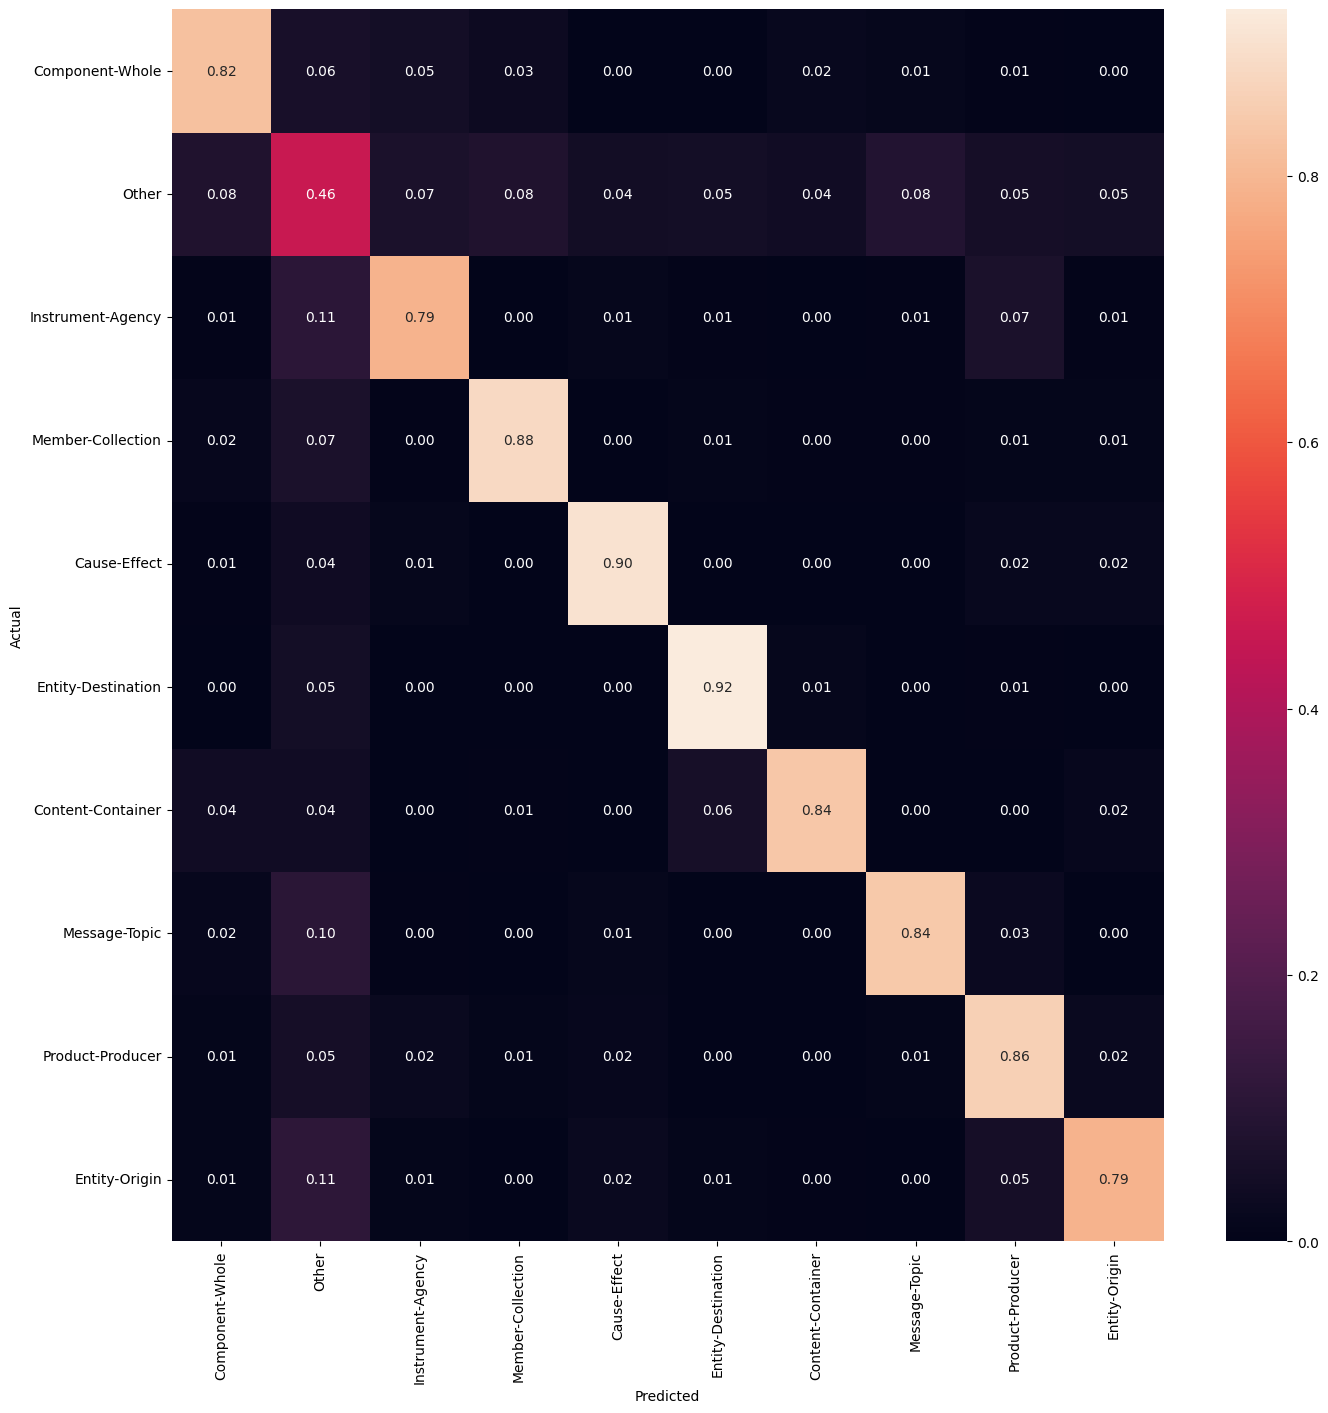

In [ ]:
cm = confusion_matrix(MTB_y_true, MTB_y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(16, 16))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=label_mapper, yticklabels=label_mapper)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
df = pd.DataFrame(classification_report(MTB_y_true, MTB_y_pred, target_names=label_mapper, output_dict=True)).transpose()
df = df.drop(index=['accuracy','macro avg','weighted avg'])
df = df.round(4)
print(tabulate(df, headers='keys', tablefmt='psql',floatfmt=".4f"))

+--------------------+-------------+----------+------------+-----------+
|                    |   precision |   recall |   f1-score |   support |
|--------------------+-------------+----------+------------+-----------|
| Component-Whole    |      0.8141 |   0.8220 |     0.8180 |  309.0000 |
| Other              |      0.5763 |   0.4554 |     0.5087 |  448.0000 |
| Instrument-Agency  |      0.6723 |   0.7881 |     0.7256 |  151.0000 |
| Member-Collection  |      0.8040 |   0.8777 |     0.8392 |  229.0000 |
| Cause-Effect       |      0.8926 |   0.9009 |     0.8968 |  323.0000 |
| Entity-Destination |      0.8766 |   0.9247 |     0.9000 |  292.0000 |
| Content-Container  |      0.8377 |   0.8377 |     0.8377 |  191.0000 |
| Message-Topic      |      0.8202 |   0.8391 |     0.8295 |  261.0000 |
| Product-Producer   |      0.7461 |   0.8565 |     0.7975 |  223.0000 |
| Entity-Origin      |      0.8340 |   0.7882 |     0.8105 |  255.0000 |
+--------------------+-------------+----------+----

In [ ]:
df.to_csv('{208542944}_{318339041}_part6.csv.csv', index=False)

<br><br><br><br><br>

## Task 7

In  this final task we will classify similar sentences (1 - similar, 0 - not similar).
We will use an `off the shelf model` and run inference.

- Get the kaggle dataset and create a inference pipeline for the Sentence similarity. Use an off-the-shelf.

Note: you may add change cells as you pleased.


Optional: Clear GPU space if needed

In [ ]:
torch.cuda.empty_cache()

Set all the relavant random seed to 111

In [ ]:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Download the `train` dataset from [here](https://github.com/saharmilis/runi-nlp/tree/main/kaggle).

In [ ]:
!git clone https://github.com/saharmilis/runi-nlp

fatal: destination path 'runi-nlp' already exists and is not an empty directory.


In [ ]:
train_data = pd.read_csv('/content/runi-nlp/kaggle/nlp_2023_train.csv')
train_data = train_data.drop(columns=['Unnamed: 0'])

Download the sentence similarty tokenizer & model `all-mpnet-base-v2`.
Here the [link](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) to the model.



In [ ]:
%pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
model.to(DEVICE)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

Run inference on the **first 5K lines** in the train dataset, and save it in a dataframe.

In [ ]:
train_data = train_data.head(5000)

text1_embeddings = model.encode(train_data['text1'].tolist())
text2_embeddings = model.encode(train_data['text2'].tolist())

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

similarities = [1 - cosine(embedding1, embedding2) for embedding1, embedding2 in zip(text1_embeddings, text2_embeddings)]

predictions = np.array([1 if similarity >= 0.5 else 0 for similarity in similarities], dtype=int)
true_labels = np.array(train_data['Similarity'].tolist(), dtype=int)

accuracy = np.sum(true_labels == predictions) / len(true_labels)

print('Predictions:', predictions)
print('True Labels:', true_labels)
print('Accuracy:', accuracy)


Predictions: [1 0 1 ... 0 1 0]
True Labels: [0 0 0 ... 0 1 0]
Accuracy: 0.5932


Print a classification report (use a simple SK-learn classification report)

In [ ]:
report = classification_report(true_labels, predictions, output_dict=True, labels=['0', '1'])
report = pd.DataFrame(report).transpose()
report = report.loc[['0', '1']][['precision', 'recall', 'f1-score']]

print(tabulate(report, headers='keys', tablefmt='psql'))

+----+-------------+----------+------------+
|    |   precision |   recall |   f1-score |
|----+-------------+----------+------------|
|  0 |    0.996795 | 0.379963 |   0.550199 |
|  1 |    0.458955 | 0.997683 |   0.628697 |
+----+-------------+----------+------------+


Save a CSV file as `{student_id_1}_{student_id_n}_part7.csv` with this format: `ID, LABEL_TRUE, LABEL_PRED`

Notice:
- Do not write the index number to the CSV file.
- Make sure the CSV file will contain only integers.


In [ ]:
df = pd.DataFrame({'ID': np.arange(0, len(predictions)), 'LABEL_TRUE': true_labels, 'LABEL_PRED': predictions})
df.to_csv('{208542944}_{318339041}_part7.csv.csv', index=False)

<br><br><br><br><br><br>
**Good luck!**